# 10 Step Phase Shifting Technique

In [21]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%autoreload 2

In [23]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import load_raw_img, rad_to_deg, mask_to_dummy
from unwrapping_isoclinic import phase_unwrap_isoclinic
from unwrapping_algorithm import phase_unwrap

### Load the 10 images

In [24]:
base_path = "img/ring/phase-shifting/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [25]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


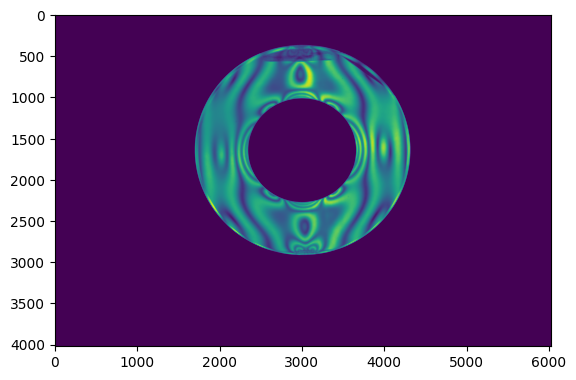

In [40]:
mask = cv.imread('img/ring/mask/ring_mask_phase_shifting.jpg', cv.IMREAD_GRAYSCALE)
plt.imshow(cv.multiply(imgs[4], mask / 255))
plt.imsave('img/ring/results/ring_image_masked.jpg', cv.multiply(imgs[4], mask / 255))

### Calculate the isoclinic parameter
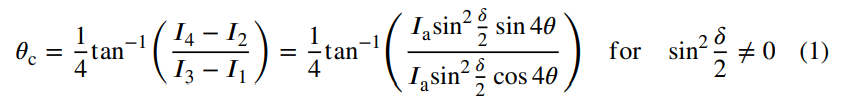

In [27]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [28]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

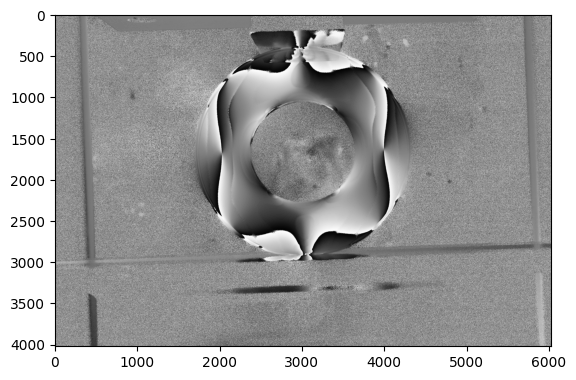

In [29]:
filename = 'img/ring/results/ring_isocl_wr.jpg'
plt.imshow(isoclinic_param, cmap='gray')
plt.imsave(filename, isoclinic_param, cmap='gray')

In [30]:
isoclinic_to_unwrap = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 

# Set stack as isotropic points
stack = [(2200, 2200), (2200, 2000), (1100, 2200), (1100, 2000), (1100, 3700), (2300, 3700), (1700, 2100)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

isoclinic_unwrapped = phase_unwrap_isoclinic(isoclinic_to_unwrap, stack, dummy)

0 7
500000 4566
1000000 5762
1500000 5471
2000000 4059
2500000 2986
3000000 2807
3500000 1860


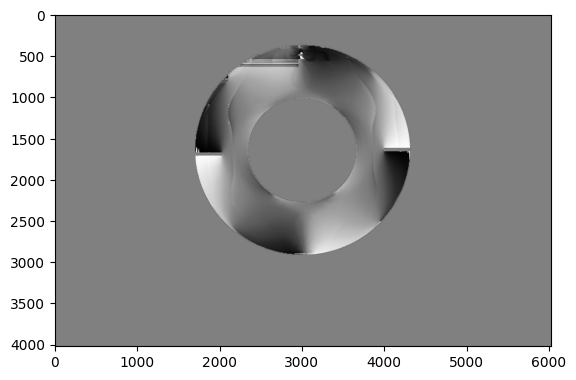

In [31]:
plt.imshow(isoclinic_unwrapped, cmap='gray')
plt.imsave('img/ring/results/ring_isocl_unwr.jpg', np.nan_to_num(isoclinic_unwrapped), cmap='gray')

### Generate isochromatic parameter
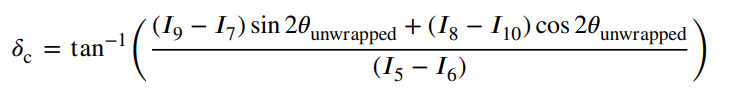


In [32]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [33]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_unwrapped
))

C:\Users\zebsu\AppData\Local\Temp\ipykernel_32292\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\zebsu\AppData\Local\Temp\ipykernel_32292\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [34]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

## Isochromatic Image Processing

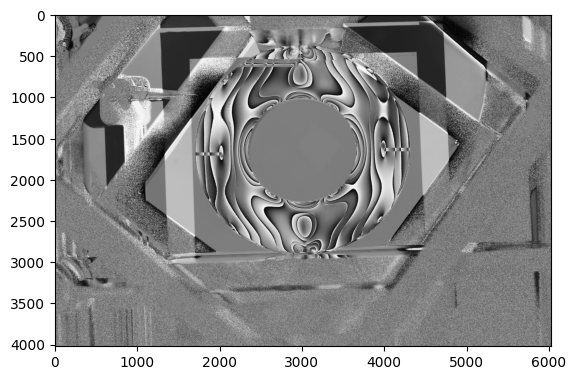

In [35]:
filename = 'img/ring/results/ring_isochr_wr_isocl_unwr.jpg'
plt.imshow(isochromatic_param, cmap='gray')
plt.imsave(filename, isochromatic_param, cmap='gray')

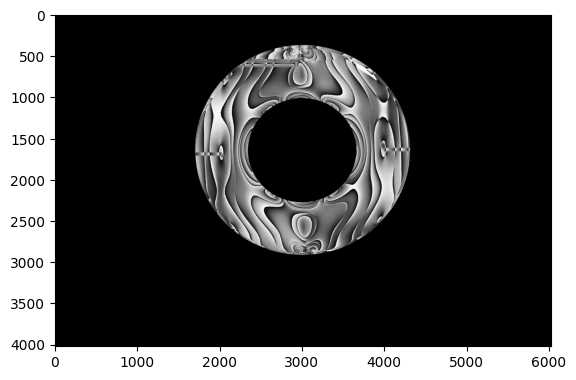

In [36]:
isochromatic_masked = cv.multiply(isochromatic_param, mask / 255)
isochromatic_masked = cv.medianBlur(isochromatic_masked.astype(np.uint8), 5)

plt.imshow(isochromatic_masked, cmap='gray')
plt.imsave('img/ring/results/ring_isochr_wr_isocl_unwr_masked.jpg',  isochromatic_masked, cmap='gray')

0 10
500000 4912
1000000 6983
1500000 8396
2000000 9302
2500000 6654
3000000 5282
3500000 2136


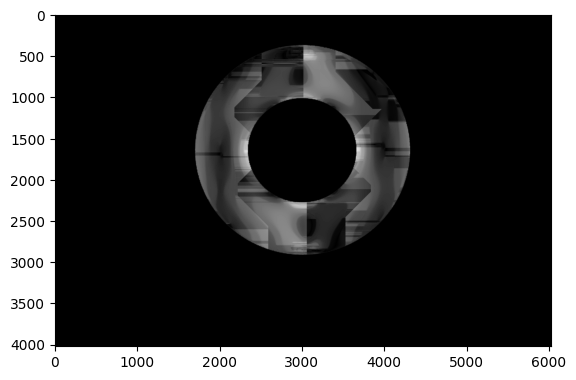

In [37]:
# Set stack as isotropic points
stack = [(1650, 2030), (1700, 3970), (2200, 2650), (2150,3400), (2570, 2150), (2460, 3950), (1130, 2600), (1150, 3400), (800, 2080), (700, 3850)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

isochromatic_unwrapped = phase_unwrap(isochromatic_masked, stack, dummy)

plt.imshow(isochromatic_unwrapped, cmap='gray')

In [38]:
filename = 'img/ring/results/ring_isochr_unwr_isocl_unwr.jpg'
plt.imsave(filename, isochromatic_unwrapped, cmap='gray')

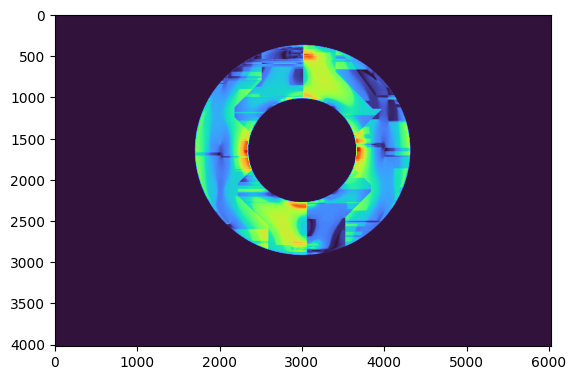

In [39]:
img = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 
plt.imshow(img, cmap='turbo')
plt.imsave('img/ring/results/ring_isochr_unwr_isocl_unwr_colour.jpg', isochromatic_unwrapped, cmap='turbo')